#Problem2
###20191128 Jian Park

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
categories = ['brontosaurus', 'car_side', 'cougar_face', 'dalmatian', 'dollar_bill', 'dragonfly', 'Faces', 'Faces_easy', 'flamingo', 'headphone', 'lotus', 'menorah', 'nautilus', 'pagoda', 'soccer_ball', 'stop_sign', 'sunflower', 'tick', 'windsor_chair', 'yin_yang']
detector = cv2.ORB_create() # ust ORB feature descriptor

In [3]:
train_path = '/content/drive/MyDrive/CSE472/dataset/train'
train_paths = []
train_labels = []
train_features = np.array([])
img_len = 30

In [4]:
for idx, category in enumerate(categories):
  dir_path = train_path + '/' + category
  
  for i in range(img_len):
    img_path = dir_path + '/' + 'image_%04d.jpg' % (i+1)
    train_paths.append(img_path)
    train_labels.append(idx)
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kpt, desc = detector.detectAndCompute(gray, None)

    if train_features.size == 0:
      train_features = np.float32(desc)
    else:
      train_features = np.append(train_features, np.float32(desc), axis=0)
    print('path %s ' % (img_path))

path /content/drive/MyDrive/CSE472/dataset/train/brontosaurus/image_0001.jpg 
path /content/drive/MyDrive/CSE472/dataset/train/brontosaurus/image_0002.jpg 
path /content/drive/MyDrive/CSE472/dataset/train/brontosaurus/image_0003.jpg 
path /content/drive/MyDrive/CSE472/dataset/train/brontosaurus/image_0004.jpg 
path /content/drive/MyDrive/CSE472/dataset/train/brontosaurus/image_0005.jpg 
path /content/drive/MyDrive/CSE472/dataset/train/brontosaurus/image_0006.jpg 
path /content/drive/MyDrive/CSE472/dataset/train/brontosaurus/image_0007.jpg 
path /content/drive/MyDrive/CSE472/dataset/train/brontosaurus/image_0008.jpg 
path /content/drive/MyDrive/CSE472/dataset/train/brontosaurus/image_0009.jpg 
path /content/drive/MyDrive/CSE472/dataset/train/brontosaurus/image_0010.jpg 
path /content/drive/MyDrive/CSE472/dataset/train/brontosaurus/image_0011.jpg 
path /content/drive/MyDrive/CSE472/dataset/train/brontosaurus/image_0012.jpg 
path /content/drive/MyDrive/CSE472/dataset/train/brontosaurus/im

In [5]:
test_path = '/content/drive/MyDrive/CSE472/dataset/test'
test_paths = []
test_labels = []
test_features = np.array([])
test_img_len = 5

In [6]:
for idx, category in enumerate(categories):
  dir_path = test_path + '/' + category
  
  for i in range(30, 30+test_img_len):
    img_path = dir_path + '/' + 'image_%04d.jpg' % (i+1)
    test_paths.append(img_path)
    test_labels.append(idx)
    # img = cv2.imread(img_path)
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # kpt, desc = detector.detectAndCompute(gray, None)

    # if test_features.size == 0:
    #   test_features = np.float32(desc)
    # else:
    #   test_features = np.append(test_features, np.float32(desc), axis=0)

In [7]:
def setKmeans(word_size):
  dict_file = '/content/drive/MyDrive/CSE472/dictionary_' + str(word_size) +'.npy'
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)
  ret, label, dictionary = cv2.kmeans(train_features, word_size, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  np.save(dict_file, dictionary)

  return dictionary

In [8]:
def setKNN(dictionary, word_size):
  knn_model_file = '/content/drive/MyDrive/CSE472/nearest_neighbor_' + str(word_size) + '.xml'
  knn = cv2.ml.KNearest_create() # use K-NN
  knn.train(dictionary, cv2.ml.ROW_SAMPLE, np.float32(range(word_size)))
  train_desc = np.float32(np.zeros((len(train_paths), word_size)))

  for i, path in  enumerate(train_paths):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kpt, desc = detector.detectAndCompute(gray, None)

    ret, result, neighbours, dist = knn.findNearest(np.float32(desc), k=1)
    hist, bins = np.histogram(np.int32(result), bins=range(word_size + 1))
    train_desc[i, :] = np.float32(hist) / np.float32(np.sum(hist))

  knn.save(knn_model_file)
  return knn, train_desc

In [17]:
def trainSVM(train_desc, word_size, kernel):
  svm_model_file = '/content/drive/MyDrive/CSE472/svmmodel_' + str(word_size) + '.xml'
  svm = cv2.ml.SVM_create()
  svm.setKernel(kernel)
  svm.trainAuto(train_desc, cv2.ml.ROW_SAMPLE, np.array(train_labels)) # C, Gamma 를 자동으로 최적화해서 train

  # trainAuto 함수로 알아낸 값을 train 이용하면 더 빠르게 가능
  # svm.setC(svm.getC())
  # svm.setGamma(svm.getGamma())
  # svm.train(trains, cv2.ml.ROW_SAMPLE, labels)

  svm.save(svm_model_file) # train 시킨 모델 저장
  return svm

In [10]:
def test(svm, knn, word_size):
  test_desc = np.float32(np.zeros((len(test_paths), word_size)))
  corr = 0

  for i, path in enumerate(test_paths):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kpt, desc = detector.detectAndCompute(gray, None)

    ret, result, neighbours, dist = knn.findNearest(np.float32(desc), k=1)
    hist, bins = np.histogram(np.int32(result), bins=range(word_size + 1))
    test_desc[i, :] = np.float32(hist) / np.float32(np.sum(hist))
    
  ret, result = svm.predict(test_desc)

  for i in range(len(test_paths)):
    pred = int(result[i][0])
    if pred == test_labels[i]:
    # if (i < (pred+1)*5) and (i >= pred * 5):
      corr += 1

  accuracy = corr / len(test_paths)

  return accuracy

In [11]:
x = np.arange(1,7)
arr = np.zeros(6)
for i in range(1, 7):
  size = i * 10
  dictionary = setKmeans(size)
  knn, train_desc = setKNN(dictionary, size)
  svm = trainSVM(train_desc, size, cv2.ml.SVM_RBF)
  accuracy = test(svm, knn, size)
  arr[i-1] = accuracy
  print(accuracy)


0.32
0.32
0.4
0.43
0.42
0.4


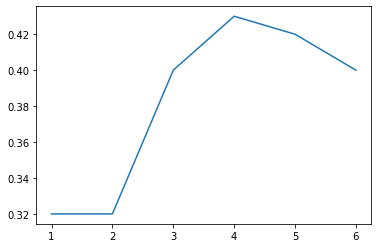

In [15]:
plt.plot(x, arr)
plt.show()

In [18]:
# histogram intersection kernel
x = np.arange(1,7)
arr = np.zeros(6)
for i in range(1, 7):
  size = i * 10
  dictionary = setKmeans(size)
  knn, train_desc = setKNN(dictionary, size)
  svm = trainSVM(train_desc, size, cv2.ml.SVM_INTER)
  accuracy = test(svm, knn, size)
  arr[i-1] = accuracy
  print(accuracy)

0.38
0.36
0.45
0.44
0.47
0.43


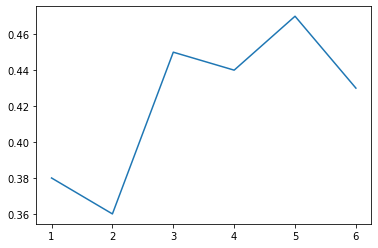

In [19]:
plt.plot(x, arr)
plt.show()